<a href="https://colab.research.google.com/github/allpirez/Modelo_RNC_IMP/blob/main/Modelo_RNC_IMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Creación de un modelo de RNC con Pytorch.

Se conecta al directorio y se instalan las bibliotecas necesarias.

In [20]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [21]:
cd "/content/gdrive/MyDrive/SaltSeg_Unet_pytorch_Segmentation_models/"

/content/gdrive/MyDrive/SaltSeg_Unet_pytorch_Segmentation_models


In [ ]:
!pip uninstall opencv-python-headless==4.5.5.62
!pip install opencv-python-headless==4.5.2.52

In [ ]:
# última versión de Albumentations
!pip install -U git+https://github.com/albumentations-team/albumentations

In [24]:
!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

Se importan las bibliotecas y modulos necesarios

In [25]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

from torchsummary import summary
import segmentation_models_pytorch as smp

from albumentations.pytorch import ToTensorV2
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Se define la ubicación de los conjuntos de datos de entrenamiento, de validación y de prueba


In [26]:
train_img_dir = "data/train_images/"
train_mask_dir = "data/train_masks/"

val_img_dir = "data/val_images/"
val_mask_dir = "data/val_masks/"

test_img_dir = "data/test_images/"
test_mask_dir = "data/test_masks/"

Creamos funciones para enlistar en un DataFrame las imágenes y vemos su longitud

In [27]:
def crear_train_df():
    nombre = []
    for dirnom, _, filenames in os.walk(train_img_dir):
        for filename in filenames:
            nombre.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': nombre}, index = np.arange(0, len(nombre)))

df = crear_train_df()
print('Total de imagenes de entrenamiento: ', len(df))

Total de imagenes de entrenamiento:  3550


In [28]:
def crear_valid_df():
    nombre = []
    for dirnom, _, filenames in os.walk(val_img_dir):
        for filename in filenames:
            nombre.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': nombre}, index = np.arange(0, len(nombre)))

df_val = crear_valid_df()
print('Total de imagenes de validación: ', len(df_val))

Total de imagenes de validación:  400


In [29]:
def crear_test_df():
    nombre = []
    for dirname, _, filenames in os.walk(test_img_dir):
        for filename in filenames:
            nombre.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': nombre}, index = np.arange(0, len(nombre)))

df_test = crear_test_df()
print('Total de imagenes de prueba: ', len(df_test))

Total de imagenes de prueba:  50


Se visualiza un ejemplo de un par de conjunto de datos de entrenamiento

Tamaño de imagen (101, 101, 3)
Tamaño de máscara (101, 101)


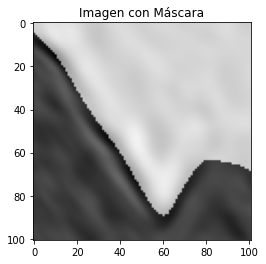

In [30]:
img = Image.open(train_img_dir + df['id'][1008] + '.png')
mask = Image.open(train_mask_dir + df['id'][1008] + '.png')
print('Tamaño de imagen', np.asarray(img).shape)
print('Tamaño de máscara', np.asarray(mask).shape)

plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Imagen con Máscara')
plt.show()

##Preparación de datos

In [31]:
class Conjunto_de_Datos(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        image = np.array(Image.open(img_path).convert("L"), dtype=np.float32)
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        image[image == 255.0] = 1.0
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

Se definen las transformaciones a realizar a las imagenes con la biblioteca Albumentations

In [32]:
mean =[0.485]
std= [0.229]

t_train = A.Compose([A.Resize(128, 128, interpolation=cv2.INTER_NEAREST), 
                     A.HorizontalFlip(p=1.0),
                      A.Blur(blur_limit=7, always_apply=False, p=0.5),
                      A.Normalize(
                          mean=mean,
                          std=std,
                          max_pixel_value=255.0,
                      ),
                      ToTensorV2()])


                    
t_val = A.Compose([A.Resize(128, 128, interpolation=cv2.INTER_NEAREST), 
                      A.Normalize(
                          mean=mean,
                          std=std,
                          max_pixel_value=255.0,
                      ),
                      ToTensorV2()])



Creamos los conjuntos de datos y los DataLoader, con el número de imagenes por lote para el entrenamiento

In [33]:
train_set = Conjunto_de_Datos(train_img_dir, train_mask_dir, t_train)
val_set = Conjunto_de_Datos(val_img_dir, val_mask_dir, t_val)
test_set = Conjunto_de_Datos(test_img_dir, test_mask_dir, t_val)

batch_size= 32 
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False) 
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False) 

In [34]:
train_features, train_labels = next(iter(train_loader))
print(f"Dimensiones del lote de características: {train_features.size()}")
print(f"Dimensiones del lote de etiquetas: {train_labels.size()}")

Dimensiones del lote de características: torch.Size([32, 1, 128, 128])
Dimensiones del lote de etiquetas: torch.Size([32, 128, 128])


## Modelo

Con la biblioteca segmentation-models-pytorch creamos el modelo de RNC. Se determinan los parámetros deseados

In [35]:
params_aux=dict(
    pooling='max',             # agrupamiento máximo
    dropout=0.5,               # proporción de abandono
    activation='sigmoid',      # función de activación
    classes=1,                 # número de etiquetas de salida (1: sal)
)

modelo = smp.Unet('resnet34', encoder_weights='imagenet', encoder_depth=4, decoder_channels=[512, 256, 128, 64], aux_params=params_aux, in_channels=1)

## Entrenamiento

Definimos los hiperparámetros deseados y se definen funciones para realizar el entrenamiento, guardar los checkpoints y evaluar el modelo durante el entrenamiento

In [36]:
Tasa_de_aprendizaje = 1e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
tamaño_de_lote = 16
num_epocas = 10
num_workers = 2
img_altura = 128  
img_ancho = 128  
pin_memory = True
load_model = False

In [37]:
def salvar_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Salvando checkpoint")
    torch.save(state, filename)

def cargar_checkpoint(checkpoint, model):
    print("=> Cargando checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def precision(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            
            a , b =model(x)

            preds = torch.sigmoid(a)
            
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8)
            
            writer.add_scalar("Dice_Score/val", dice_score/len(loader), epoch)
            writer.add_scalar("Acc/val", num_correct/num_pixels*100, epoch)
            
    print(
        f"Se obtuvo {num_correct}/{num_pixels} con precisión {num_correct/num_pixels*100:.2f}"
    )
    print(f"Coeficiente Dice: {dice_score/len(loader)}") 

    model.train()
    return dice_score


def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=device)
        model = model.to(device)
        targets = targets.float().unsqueeze(1).to(device=device)

        running_loss=0
        loss_values =[]

        # hacia adelante
        with torch.cuda.amp.autocast():
            predictions, _ = model(data)

            loss = loss_fn(predictions, targets)
            writer.add_scalar("Loss/train", loss, epoch)

        # hacia atrás
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        loss_values.append(running_loss/len(train_set))
            
        

        

        # se actualiza el loop tqdm
        loop.set_postfix(loss=loss.item())
    return loss_values

        

Se define la función costo, el optimizador y el escalador

In [38]:
writer = SummaryWriter()

costo = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(modelo.parameters(), lr=Tasa_de_aprendizaje)


if load_model:
  cargar_checkpoint(torch.load("my_checkpoint_1canal.pth.tar"), modelo)

scaler = torch.cuda.amp.GradScaler()

for epoch in range(num_epocas):
  running_loss=0
  train_fn(train_loader, modelo, optimizer, costo, scaler)
  

  # salva el modelo
  checkpoint = {
      "state_dict": modelo.state_dict(),
      "optimizer":optimizer.state_dict(),
      }
      
  salvar_checkpoint(checkpoint)

  # revisar precisión
  precision(val_loader, modelo, device=device)
      
writer.flush()
writer.close()

  0%|          | 0/111 [00:00<?, ?it/s]

=> Salvando checkpoint
Se obtuvo 6162748/6553600 con precisión 94.04
Coeficiente Dice: 0.8686046004295349


  0%|          | 0/111 [00:00<?, ?it/s]

=> Salvando checkpoint
Se obtuvo 6180839/6553600 con precisión 94.31
Coeficiente Dice: 0.8746996521949768


  0%|          | 0/111 [00:00<?, ?it/s]

=> Salvando checkpoint
Se obtuvo 6185193/6553600 con precisión 94.38
Coeficiente Dice: 0.8750669360160828


  0%|          | 0/111 [00:00<?, ?it/s]

=> Salvando checkpoint
Se obtuvo 6202657/6553600 con precisión 94.65
Coeficiente Dice: 0.8842927813529968


  0%|          | 0/111 [00:00<?, ?it/s]

=> Salvando checkpoint
Se obtuvo 6210351/6553600 con precisión 94.76
Coeficiente Dice: 0.8872275948524475


  0%|          | 0/111 [00:00<?, ?it/s]

=> Salvando checkpoint
Se obtuvo 6248712/6553600 con precisión 95.35
Coeficiente Dice: 0.8991008400917053


  0%|          | 0/111 [00:00<?, ?it/s]

=> Salvando checkpoint
Se obtuvo 6183301/6553600 con precisión 94.35
Coeficiente Dice: 0.876862108707428


  0%|          | 0/111 [00:00<?, ?it/s]

=> Salvando checkpoint
Se obtuvo 6202837/6553600 con precisión 94.65
Coeficiente Dice: 0.8859770894050598


  0%|          | 0/111 [00:00<?, ?it/s]

=> Salvando checkpoint
Se obtuvo 6235981/6553600 con precisión 95.15
Coeficiente Dice: 0.8984324932098389


  0%|          | 0/111 [00:00<?, ?it/s]

=> Salvando checkpoint
Se obtuvo 6227093/6553600 con precisión 95.02
Coeficiente Dice: 0.8950625061988831


##Evaluación

Evaluamos la precisión con el conjunto de datos de prueba

In [39]:
precision(test_loader, modelo, device=device)

Se obtuvo 796213/819200 con precisión 97.19
Coeficiente Dice: 0.9574776887893677


tensor(1.9150, device='cuda:0')